In [1]:
import pandas as pd
import os
import shutil

In [2]:
# Creating data for positive samples
FILE_PATH="chestxray/metadata.csv"
IMAGES_PATH="chestxray/images"

In [3]:
df=pd.read_csv(FILE_PATH)
print(df.shape)

(950, 30)


In [4]:
df.head()

,patientid,offset,sex,age,finding,RT_PCR_positive,survival,intubated,intubation_present,went_icu,...,date,location,folder,filename,doi,url,license,clinical_notes,other_notes,Unnamed: 29
0,2,0.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,"January 22, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
1,2,3.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,"January 25, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
2,2,5.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,"January 27, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
3,2,6.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,"January 28, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
4,4,0.0,F,52.0,Pneumonia/Viral/COVID-19,Y,NaN,N,N,N,...,"January 25, 2020","Changhua Christian Hospital, Changhua City, Ta...",images,nejmc2001573_f1a.jpeg,10.1056/NEJMc2001573,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,diffuse infiltrates in the bilateral lower lungs,NaN,NaN


In [5]:
TARGET_DIR="Dataset/Covid"

if not os.path.exists(TARGET_DIR):
    os.mkdir(TARGET_DIR)
    print("Covid folder created!")

In [6]:
for (i,row) in df.iterrows():
    if row['finding']=='Pneumonia/Viral/COVID-19' and row['view']=='PA':
        filename=row['filename']
        image_path=os.path.join(IMAGES_PATH,filename)
        target_image_path=os.path.join(TARGET_DIR,filename)
        shutil.copy2(image_path,target_image_path)      

In [7]:
# Sampling impages from kaggle dataset
KAGGLE_IMAGE_PATH="chest_xray_kaggle/test/NORMAL"
TARGET_PATH="Dataset/Normal"

In [8]:
import random
image_names=os.listdir(KAGGLE_IMAGE_PATH)
random.shuffle(image_names)
for i in range (200):
    image_name=image_names[i]
    image_path=os.path.join(KAGGLE_IMAGE_PATH,image_name)
    target_image_path=os.path.join(TARGET_PATH,image_name)
    shutil.copy2(image_path,target_image_path)

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.layers import *
from keras.models import *
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [10]:
# CNN Based Model in Keras
model = Sequential()
model.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(224,224,3)))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25)) #To avoid Overfitting

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(256,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.50))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1,activation='sigmoid'))

model.compile(loss=keras.losses.binary_crossentropy,optimizer='adam',metrics=['accuracy'])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 64)      18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 110, 110, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 54, 54, 128)       0

In [12]:
train_datagen=image.ImageDataGenerator(
                rescale=1./255,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True)
val_datagen=image.ImageDataGenerator(rescale=1./255)
test_datagen=image.ImageDataGenerator(rescale=1./255)

In [13]:
train_generator=train_datagen.flow_from_directory(
                'Dataset/Train',
                target_size=(224,224),
                batch_size=32,
                class_mode='binary')

Found 280 images belonging to 2 classes.


In [14]:
train_generator.class_indices

{'Covid': 0, 'Normal': 1}

In [15]:
test_generator=test_datagen.flow_from_directory(
                'Dataset/Test',
                target_size=(224,224),
                batch_size=32,
                class_mode='binary')

Found 60 images belonging to 2 classes.


In [16]:
val_generator=test_datagen.flow_from_directory(
                'Dataset/Val',
                target_size=(224,224),
                batch_size=32,
                class_mode='binary')

Found 56 images belonging to 2 classes.


In [17]:
checkpoint=ModelCheckpoint("Covid_best_model.hdf5",monitor='accuracy',verbose=1,save_best_only=True,mode='max')

In [18]:
final=model.fit(
            train_generator,
            steps_per_epoch=8,
            epochs=20,
            validation_data=val_generator,
            validation_steps=2,
            callbacks=[checkpoint])

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpqencpnsl.py, line 48)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpqencpnsl.py, line 48)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
8/8 [==============================] - 119s 9s/step - loss: 0.9450 - accuracy: 0.5022 - val_loss: 0.6891 - val_accuracy: 0.5000

Epoch 00001: accuracy improved from -inf to 0.53629, saving model to Covid_best_model.hdf5
Epoch 2/20
8/8 [==============================] - 85s 10s/step - loss: 0.6925 - accuracy: 0.5257 - val_loss: 0.6720 - val_accuracy: 0.9286

Epoch 00002: accuracy imp

In [19]:
model.evaluate(test_generator)

2/2 [==============================] - 4s 1s/step - loss: 0.0787 - accuracy: 0.9833


[0.07874821126461029, 0.9833333492279053]

In [20]:
import os

In [21]:
y_actual=[]
y_test=[]

In [22]:
for i in os.listdir("./Dataset/test/Covid/"):
    img=image.load_img("./Dataset/test/Covid/"+i,color_mode="rgb", target_size=(224,224,3))
    img=image.img_to_array(img)
    img=np.expand_dims(img,axis=0)
    p=model.predict_classes(img)
    y_test.append(p[0,0])
    y_actual.append(0)

c:\users\acer\appdata\local\programs\python\python39\lib\site-packages\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [23]:
for i in os.listdir("./Dataset/test/Normal/"):
    img=image.load_img("./Dataset/test/Normal/"+i,color_mode="rgb", target_size=(224,224,3))
    img=image.img_to_array(img)
    img=np.expand_dims(img,axis=0)
    p=model.predict_classes(img)
    y_test.append(p[0,0])
    y_actual.append(1)

In [24]:
y_test=np.array(y_test)
y_actual=np.array(y_actual)

In [25]:
from sklearn.metrics import confusion_matrix

In [26]:
cm=confusion_matrix(y_actual,y_test)

In [27]:
import seaborn as sns

<AxesSubplot:>

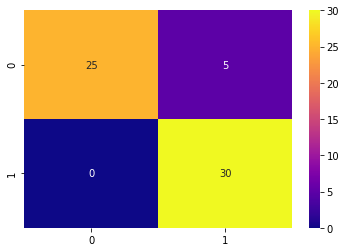

In [28]:
sns.heatmap(cm,cmap="plasma",annot=True)

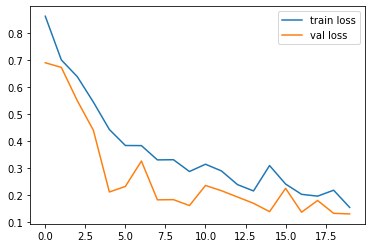

<Figure size 432x288 with 0 Axes>

In [29]:
plt.plot(final.history['loss'], label='train loss')
plt.plot(final.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

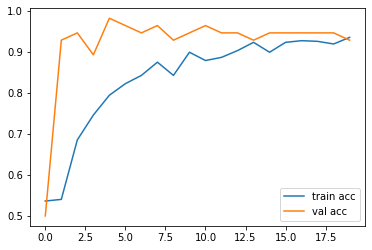

<Figure size 432x288 with 0 Axes>

In [30]:
plt.plot(final.history['accuracy'], label='train acc')
plt.plot(final.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [34]:
import pickle
import joblib
# pickle.dump(final,open('covid_19.pkl','wb'))